In [ ]:
from google.colab import drive
import os

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import librosa

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.utils import to_categorical

from scipy.stats import spearmanr

# Wczytanie danych

In [ ]:
drive.mount('/content/drive')

# Ścieżki do folderów i plików na Google Drive
folder_nadrzedny = '/content/drive/My Drive/Statystyka Wielowymiarowa - Zadanie 2'
folder_audio = os.path.join(folder_nadrzedny, 'piosenki - audio')
folder_oryginalne = os.path.join(folder_nadrzedny, 'oryginalne piosenki')
plik_csv = os.path.join(folder_nadrzedny, 'etykiety piosenek.csv')
sampling_rate = 44100

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_dataframe = pd.read_csv(plik_csv);
csv_dataframe.head()
print(len(csv_dataframe.index))
genres = csv_dataframe['Gatunek'].unique().tolist()
print(genres)
csv_dataframe.head()

249
['rock', 'pop', 'hiphop', 'klasyczna', 'metal']


,Sciezka,Gatunek
0,/content/drive/My Drive/Statystyka Wielowymiar...,rock
1,/content/drive/My Drive/Statystyka Wielowymiar...,rock
2,/content/drive/My Drive/Statystyka Wielowymiar...,rock
3,/content/drive/My Drive/Statystyka Wielowymiar...,rock
4,/content/drive/My Drive/Statystyka Wielowymiar...,rock


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Zadanie 1
- ekstrakcja cech,
- PCA - pełna analiza - sprawdzenie korelacji, indywidualna i skumulowana wyjaśniona wariancja,  
- Stworzenie modelu Sieci,
- Ocena Klasyfikacji - krzywe uczenia, metryki klasyfikatora, macierz pomyłek, walidacja krzyżowa.

## Ekstrakcja cech

In [ ]:
headers = ["stft", "cqt", "centroid", "bandwidth", "rollof", "tempo", "rms", "zero_crossing_rate"]
headers = headers + ["genre"]

In [ ]:
print(type(csv_dataframe))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
list_w_features = []

def get_feature_vector(y,sr):
  fn_list_i = [
    librosa.feature.chroma_stft,
    librosa.feature.chroma_cqt,
    librosa.feature.spectral_centroid,
    librosa.feature.spectral_bandwidth,
    librosa.feature.spectral_rolloff,
    librosa.feature.tempo,

  ]

  fn_list_ii = [
    librosa.feature.rms,
    librosa.feature.zero_crossing_rate
  ]
  feat_vect_i = [ np.mean(funct(y=y,sr=sr)) for funct in fn_list_i ]
  feat_vect_ii = [ np.mean(funct(y=y)) for funct in fn_list_ii ]
  feature_vector = feat_vect_i + feat_vect_ii
  return feature_vector



for i in range(len(csv_dataframe.index)):
  audio_data = librosa.load(csv_dataframe['Sciezka'][i].replace("\'", "_").replace('\"', '_'))

  c = get_feature_vector(y=audio_data[0], sr=audio_data[1])
  cat = csv_dataframe['Gatunek'][i]
  c.append(cat)

  list_w_features.append(c)
  if(i%10==0):
    print(i)
print(list_w_features)

df = pd.DataFrame(list_w_features, columns=headers)
df.to_csv('/content/drive/My Drive/Statystyka Wielowymiarowa - Zadanie 2/z_cechami.csv')



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
[[0.4218126, 0.62775207, 2493.693745295538, 2410.9411019882205, 5272.976448366147, 129.19921875, 0.16349483, 0.11070605771091331, 'rock'], [0.4653885, 0.6338625, 2710.2517171507925, 2715.7457213133316, 5981.013833627612, 129.19921875, 0.17189418, 0.10545967976006192, 'rock'], [0.40616247, 0.61969185, 2890.913614281895, 2688.700583277085, 6104.404754166264, 129.19921875, 0.19282573, 0.13506834425793343, 'rock'], [0.42375278, 0.63148797, 2723.2909493928137, 2622.356060849861, 5821.881462545956, 129.19921875, 0.18827096, 0.12263720249613003, 'rock'], [0.36412415, 0.6425348, 2891.779676753211, 2609.214652310811, 5958.45563670061, 129.19921875, 0.20492426, 0.14477765818498453, 'rock'], [0.43421626, 0.6070602, 1610.8850126050324, 1712.6347558393031, 3226.7971546657313, 112.34714673913044, 0.06327215, 0.06972709159732972, 'rock'], [0.50010705, 0.63224983, 2262.6913319896994, 2264.1116737231373, 4521.87265

Wyekstrahowane cechy są zapisywane do pliku, aby za każdym razem nie trzeba było uruchamiać powyższej komórki

## Analiza wyekstrachowanych cech
### Wczytanie z pliku

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Statystyka Wielowymiarowa - Zadanie 2/z_cechami.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,stft,cqt,centroid,bandwidth,rollof,tempo,rms,zero_crossing_rate,genre
0,0.421813,0.627752,2493.693745,2410.941102,5272.976448,129.199219,0.163495,0.110706,rock
1,0.465388,0.633862,2710.251717,2715.745721,5981.013834,129.199219,0.171894,0.105460,rock
2,0.406162,0.619692,2890.913614,2688.700583,6104.404754,129.199219,0.192826,0.135068,rock
3,0.423753,0.631488,2723.290949,2622.356061,5821.881463,129.199219,0.188271,0.122637,rock
4,0.364124,0.642535,2891.779677,2609.214652,5958.455637,129.199219,0.204924,0.144778,rock


### Dodanie kategorii

In [ ]:
genres = df['genre'].unique().tolist()

for genre in genres:
  df[genre] = np.where(df['genre'] == genre, True, False)

df.head()

,stft,cqt,centroid,bandwidth,rollof,tempo,rms,zero_crossing_rate,genre,rock,pop,hiphop,klasyczna,metal
0,0.421813,0.627752,2493.693745,2410.941102,5272.976448,129.199219,0.163495,0.110706,rock,True,False,False,False,False
1,0.465388,0.633862,2710.251717,2715.745721,5981.013834,129.199219,0.171894,0.105460,rock,True,False,False,False,False
2,0.406162,0.619692,2890.913614,2688.700583,6104.404754,129.199219,0.192826,0.135068,rock,True,False,False,False,False
3,0.423753,0.631488,2723.290949,2622.356061,5821.881463,129.199219,0.188271,0.122637,rock,True,False,False,False,False
4,0.364124,0.642535,2891.779677,2609.214652,5958.455637,129.199219,0.204924,0.144778,rock,True,False,False,False,False


### Min max scaler

In [ ]:
df_scaled = df.drop(columns=["genre"])
scaler = MinMaxScaler().fit(df_scaled)
df_scaled = scaler.transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns=headers[:-1] + genres)
df_scaled.head()

,stft,cqt,centroid,bandwidth,rollof,tempo,rms,zero_crossing_rate,rock,pop,hiphop,klasyczna,metal
0,0.646826,0.894351,0.633388,0.751020,0.687342,0.529412,0.363789,0.478005,1.0,0.0,0.0,0.0,0.0
1,0.762366,0.908621,0.707869,0.880504,0.796544,0.529412,0.383234,0.446283,1.0,0.0,0.0,0.0,0.0
2,0.605331,0.875528,0.770005,0.869015,0.815575,0.529412,0.431691,0.625308,1.0,0.0,0.0,0.0,0.0
3,0.651971,0.903076,0.712354,0.840831,0.772001,0.529412,0.421147,0.550145,1.0,0.0,0.0,0.0,0.0
4,0.493867,0.928874,0.770303,0.835249,0.793065,0.529412,0.459700,0.684014,1.0,0.0,0.0,0.0,0.0


## Analiza liniowości i normalności rozkładów

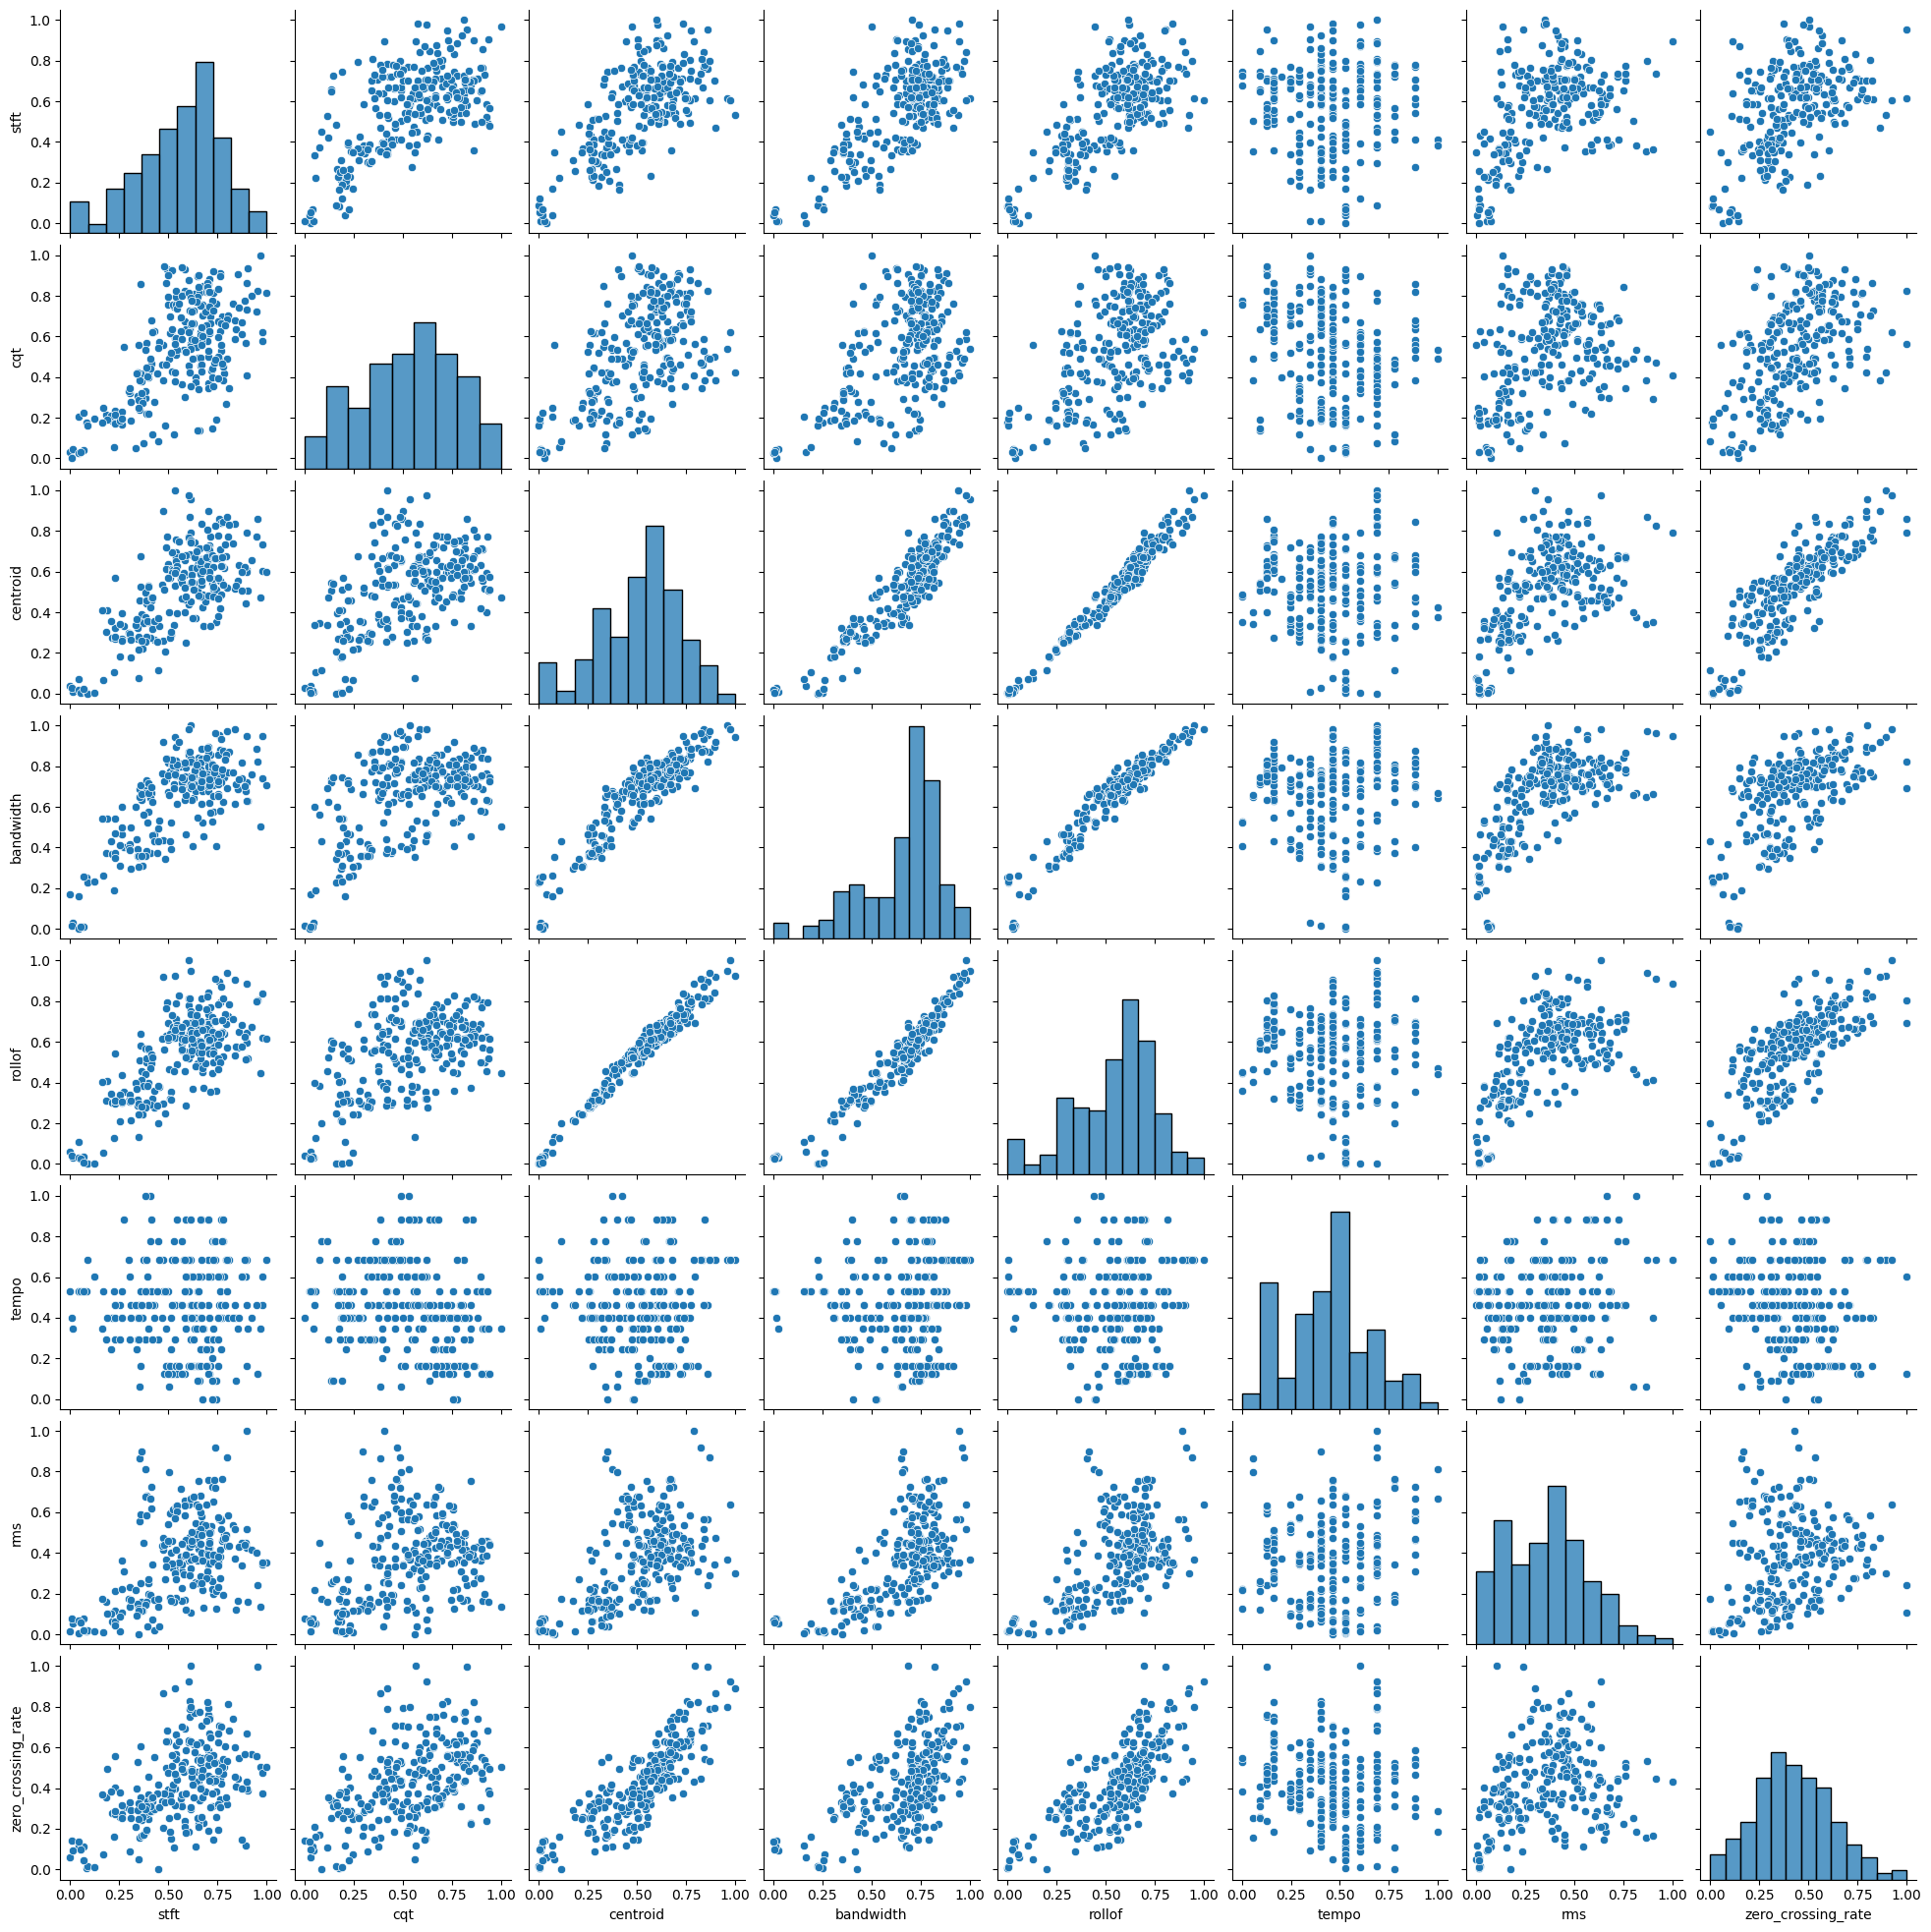

In [ ]:
sns.pairplot(df_scaled[headers[:-1]])

rolof/centroid i rolof/bandwidth są liniowo zależne. Natomist można znaleźć rozkłady od siebie niezależne, jak np. rollof/cqt. Tak samo są rozkłady zupełnie niezbliżone do normalnych, jak np. bandwidth.

Ponieważ nie można spełnić wymogu normalności rozkładów i liniowości międdzy nimi, należy obliczyć macierz korelacji metodą spearmana. Aby można było użyć metody Pearsona, te dwa warunki musiałyby być spełnione.


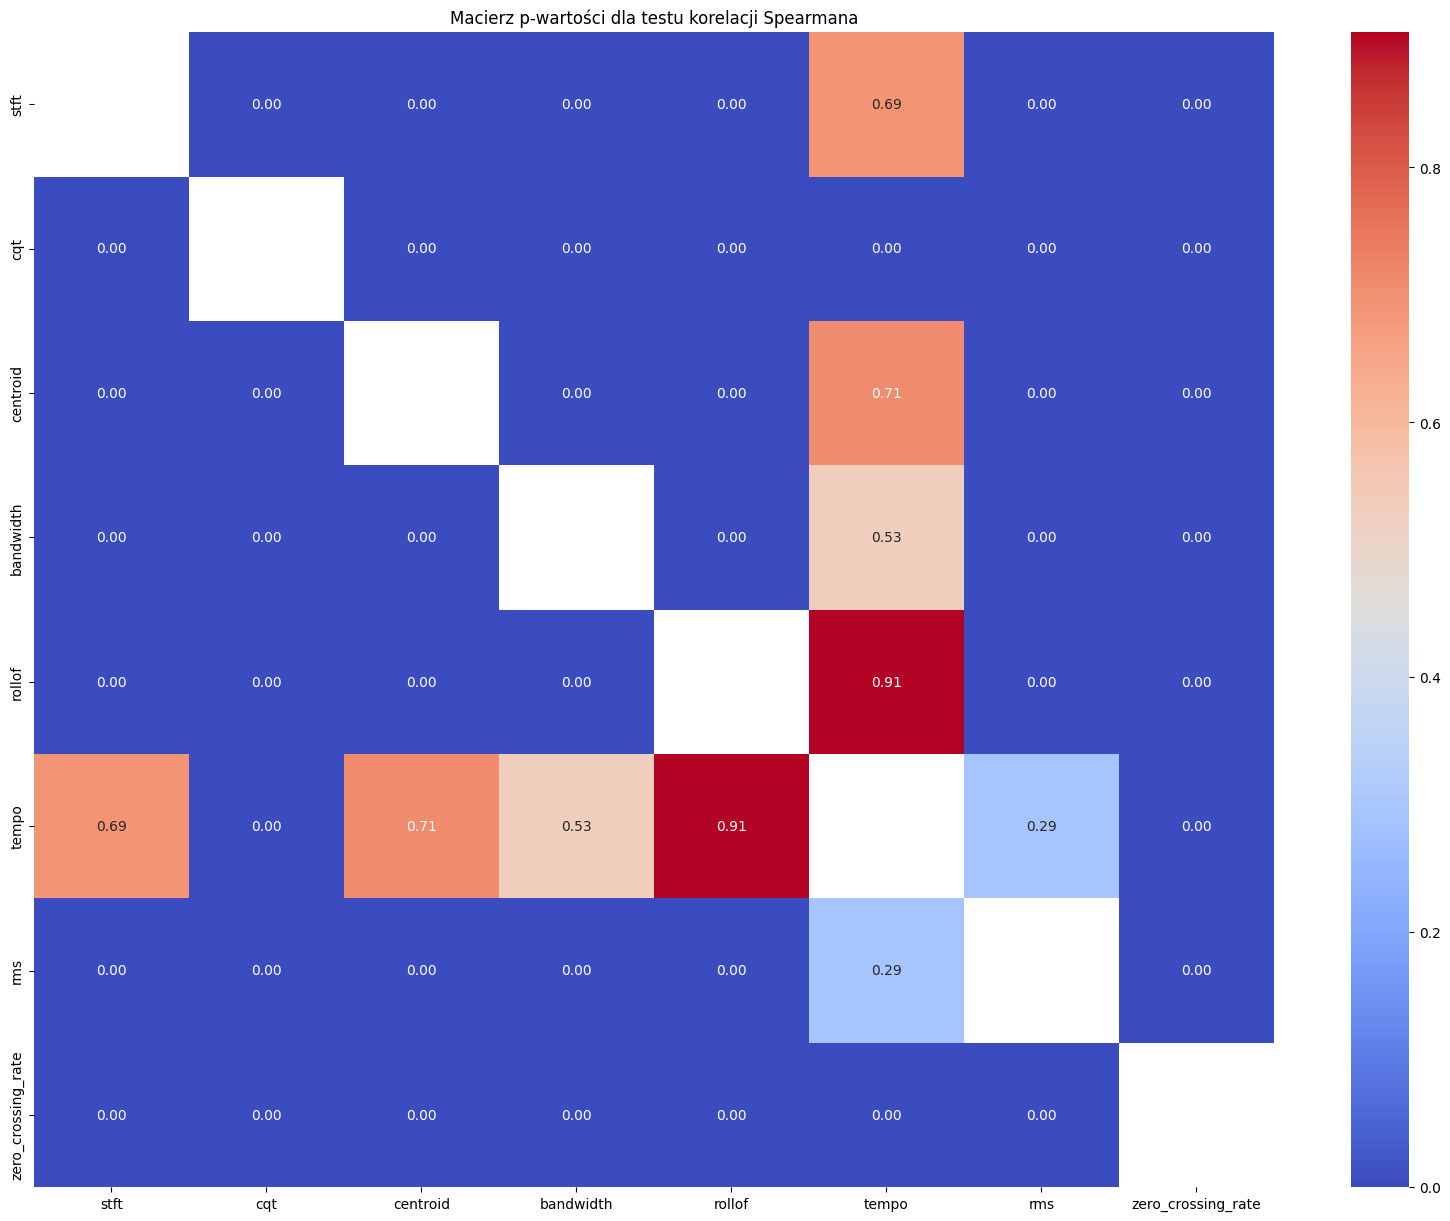

In [ ]:

spearman_corr_matrix = df_scaled.drop(columns=genres).corr(method='spearman')
spearman_p_values_matrix = pd.DataFrame(index=spearman_corr_matrix.columns, columns=spearman_corr_matrix.columns)

for row in spearman_corr_matrix.columns:
    for col in spearman_corr_matrix.columns:
        if row != col:
            # Spearman's correlation test
            spearman_corr, p_value = spearmanr(df_scaled[row], df_scaled[col])
            spearman_p_values_matrix.loc[row, col] = p_value
        else:
            # Dla tej samej zmiennej ustawiamy NaN
            spearman_p_values_matrix.loc[row, col] = np.nan

# Ustawienie odpowiedniego formatowania dla lepszej czytelności
spearman_p_values_formatted = spearman_p_values_matrix.applymap(lambda x: f'{x:.4f}' if pd.notnull(x) else 'NaN')

# Wizualizacja p-wartości dla testu korelacji Spearmana
plt.figure(figsize=(20, 15))
sns.heatmap(spearman_p_values_matrix.astype(float), annot=True, fmt='.2f', cmap='coolwarm', mask=np.eye(len(spearman_corr_matrix)))
plt.title('Macierz p-wartości dla testu korelacji Spearmana')
plt.show()

Z macierzy wynika, że istotność statystyczna między rollof a tempo jest na bardzo wysokim poziomie - 0.91. Tempo jest jeszcze zależne od bandwidth, centroid i stft z dużą istotnością statystyczną.

## Scree plot
wykres wartości własnych (eigenvalues) i jak kolejne wartości własne opisują oryginalną przestrzeń.

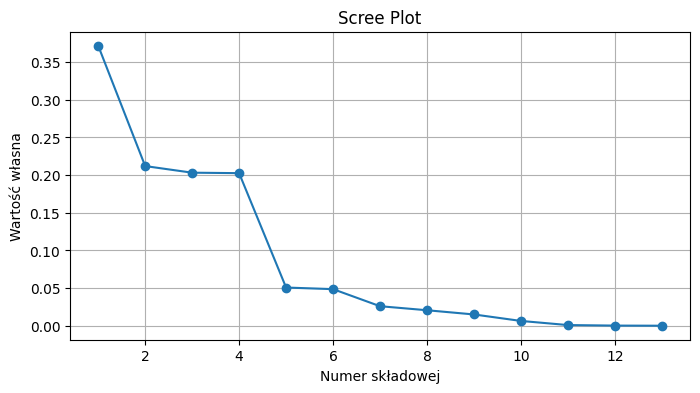

In [ ]:
cov_matrix = np.cov(df_scaled.T)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Scree plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues[::-1], 'o-')
plt.title('Scree Plot')
plt.xlabel('Numer składowej')
plt.ylabel('Wartość własna')
plt.grid()
plt.show()

## Analiza PCA

Bazując na powyższym wykresie, biorę 5 składowych PCA

In [ ]:
from operator import add
pca_v = 5
pca = PCA(n_components=pca_v)
X_pca = pca.fit_transform(df_scaled[headers[0:-1]])

i = 0

genres_as_one = [0]*len(df[genre])

for genre in genres:
  genres_as_one = list( map(add, genres_as_one, df[genre]*i) )
  i+=1

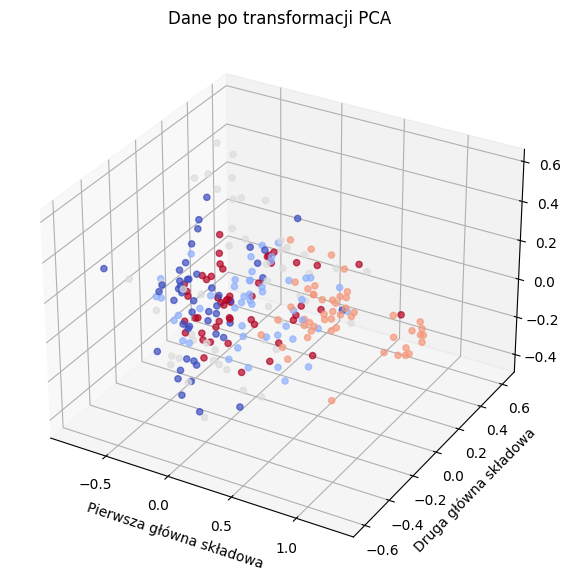

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=genres_as_one, cmap='coolwarm', alpha=0.7)
plt.title('Dane po transformacji PCA')
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
# plt.zlabel('Trzecia')
plt.grid()
plt.show()

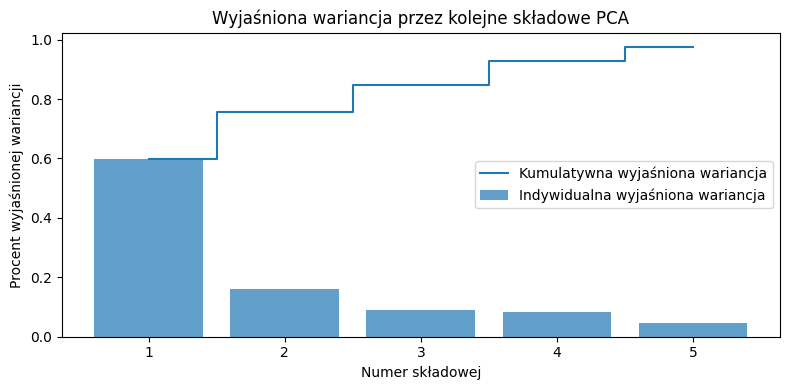

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Indywidualna wyjaśniona wariancja')
plt.step(range(1, len(explained_variance) + 1), cumulative_explained_variance, where='mid', label='Kumulatywna wyjaśniona wariancja')
plt.title('Wyjaśniona wariancja przez kolejne składowe PCA')
plt.xlabel('Numer składowej')
plt.ylabel('Procent wyjaśnionej wariancji')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Jak widać, 5 wartości PCA opisuje całą przestrzeń oryginalną prawie w 100%. Dlatego można by nawet zmniejszyć ilość składowych do 3 lub 4.

## Sieć nauczona na wartościach PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_scaled[genres], test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(pca_v, input_shape=[pca_v], activation='relu'),
    tf.keras.layers.Dense(len(genres), activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
display(model.summary())

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=100,
    verbose=False,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60 (240.00 Byte)
Trainable params: 60 (240.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

<Axes: >

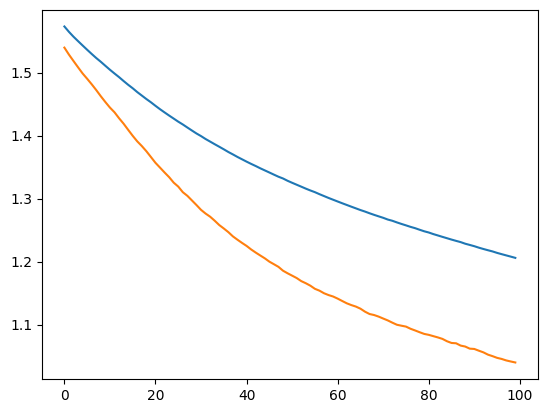

In [ ]:
history_df = pd.DataFrame(history.history)
history_df['loss'].plot()
history_df['val_loss'].plot()

2/2 [==============================] - 0s 5ms/step


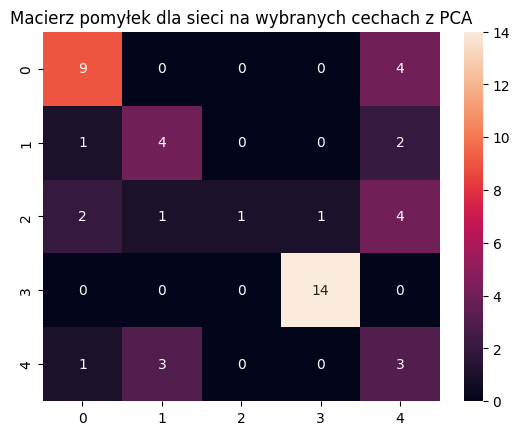

Raport klasyfikacji dla sieci na wybranych cechach z PCA:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.50      0.57      0.53         7
           2       1.00      0.11      0.20         9
           3       0.93      1.00      0.97        14
           4       0.23      0.43      0.30         7

    accuracy                           0.62        50
   macro avg       0.67      0.56      0.54        50
weighted avg       0.72      0.62      0.60        50



In [ ]:

Y_pred = np.argmax(model.predict(X_test),axis=1)

Y_test2 = np.argmax(y_test.values.tolist(), axis=1)

confusion_m = confusion_matrix(Y_test2, Y_pred)
classification_r = classification_report(Y_test2, Y_pred)

# Wizualizacja macierzy pomyłek dla wybranych cech z PCA
sns.heatmap(confusion_m, annot=True, fmt="d")
plt.title('Macierz pomyłek dla sieci na wybranych cechach z PCA')
plt.show()

# Wyświetlenie raportu klasyfikacji dla wybranych cech z PCA
print("Raport klasyfikacji dla sieci na wybranych cechach z PCA:")
print(classification_r)

## RandomForestClassifier nauczony na wartościach PCA

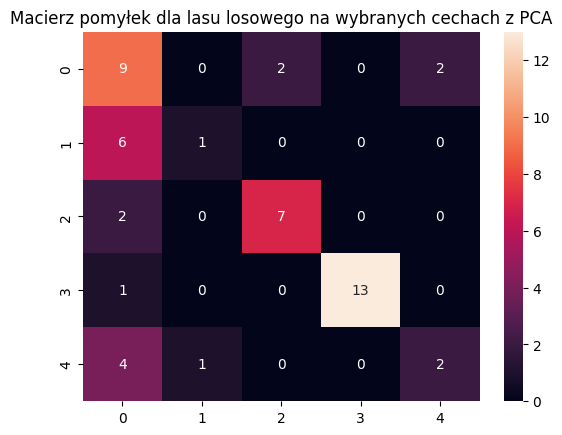

Raport klasyfikacji dla lasu losowego na wybranych cechach z PCA:
              precision    recall  f1-score   support

           0       0.41      0.69      0.51        13
           1       0.50      0.14      0.22         7
           2       0.78      0.78      0.78         9
           3       1.00      0.93      0.96        14
           4       0.50      0.29      0.36         7

    accuracy                           0.64        50
   macro avg       0.64      0.57      0.57        50
weighted avg       0.67      0.64      0.63        50



In [ ]:
rf_classifier_pca_selected = RandomForestClassifier(random_state=42)
rf_classifier_pca_selected.fit(X_train, y_train)

# Prognozy i metryki dla wybranych cech z PCA
rf_predictions_pca_selected = rf_classifier_pca_selected.predict(X_test)
rf_predictions_pca_selected = np.argmax(rf_predictions_pca_selected,axis=1)

rf_confusion_matrix_pca_selected = confusion_matrix(Y_test2, rf_predictions_pca_selected)
rf_classification_report_pca_selected = classification_report(Y_test2, rf_predictions_pca_selected)

# Wizualizacja macierzy pomyłek dla wybranych cech z PCA
sns.heatmap(rf_confusion_matrix_pca_selected, annot=True, fmt="d")
plt.title('Macierz pomyłek dla lasu losowego na wybranych cechach z PCA')
plt.show()

# Wyświetlenie raportu klasyfikacji dla wybranych cech z PCA
print("Raport klasyfikacji dla lasu losowego na wybranych cechach z PCA:")
print(rf_classification_report_pca_selected)

# Zadanie 2
- Wygenerowanie spektrogramów,
- Stworzenie modelu sieci CNN,
- Ocena Klasyfikacji - krzywe uczenia, metryki klasyfikatora, macierz pomyłek.

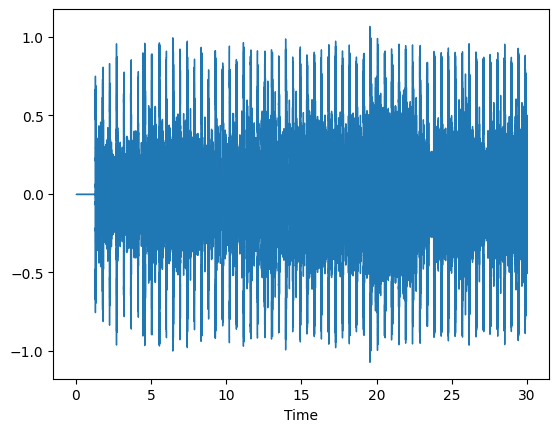

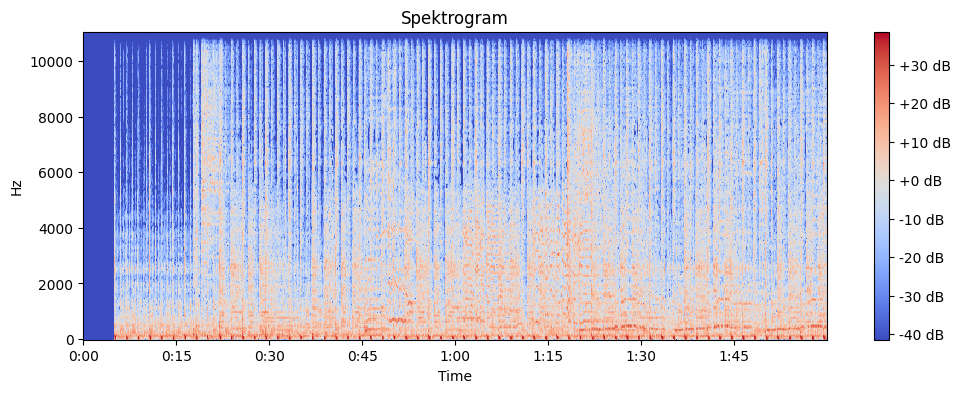

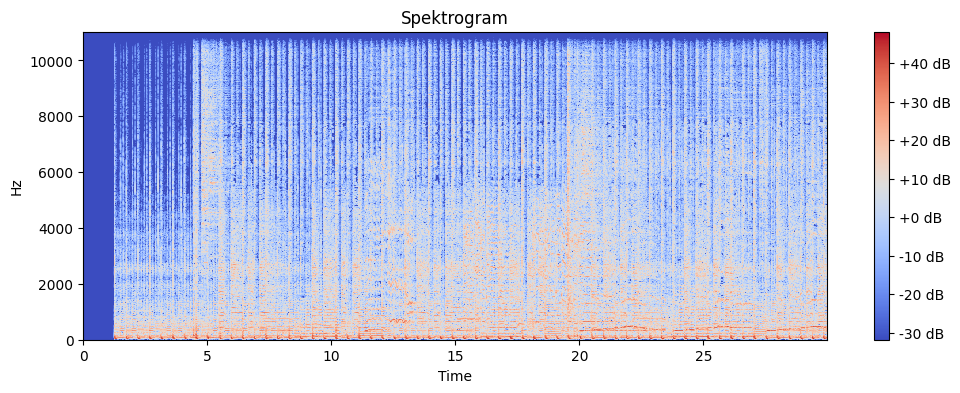

In [ ]:
audio_data = librosa.load(csv_dataframe['Sciezka'][0].replace("\'", "_").replace('\"', '_'))
librosa.display.waveshow(audio_data[0], sr=audio_data[1])
stft = librosa.stft(audio_data[0], n_fft=512, hop_length=128)
spectrogram = librosa.amplitude_to_db(abs(stft))

plt.figure(figsize=(12, 4))
librosa.display.specshow(spectrogram, sr=audio_data[1], x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spektrogram')
plt.show()

plt.figure(figsize=(12, 4))
img = librosa.display.specshow(librosa.power_to_db(abs(librosa.stft(audio_data[0]))**2), sr=audio_data[1], x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spektrogram')
plt.show()

In [ ]:
print(spectrogram.shape)

(257, 5168)


In [ ]:
X = []
y = []
for i in range(len(csv_dataframe.index)):
  audio_data = librosa.load(csv_dataframe['Sciezka'][i].replace("\'", "_").replace('\"', '_'))
  stft = librosa.stft(audio_data[0], n_fft=512, hop_length=2048)
  spectrogram = librosa.power_to_db(abs(stft))
  genre = csv_dataframe['Gatunek'][i]
  X.append(spectrogram)
  y.append(genres.index(genre))
  # print(genres.index(genre))
  if(i%10 == 0):
    print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [ ]:
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [ ]:
# for i in X[0:10]:
#   plt.figure(figsize=(12, 4))
#   plt.imshow(i)
#   plt.show()

In [ ]:
X = np.array(X)[..., np.newaxis]
y_categorical = np.array(to_categorical(y))
X = (X - np.min(X)) / (np.max(X) - np.min(X))

print(np.min(X), np.max(X))

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

0.0 1.0
(199, 257, 323, 1)
(199, 5)
(50, 257, 323, 1)
(50, 5)


In [ ]:
print(y_categorical)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(genres), activation='softmax'))

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=8)

Epoch 1/40
25/25 [==============================] - 5s 54ms/step - loss: 3.6824 - accuracy: 0.1759 - val_loss: 1.6084 - val_accuracy: 0.2600
Epoch 2/40
25/25 [==============================] - 1s 25ms/step - loss: 1.6104 - accuracy: 0.2010 - val_loss: 1.6091 - val_accuracy: 0.1800
Epoch 3/40
25/25 [==============================] - 1s 22ms/step - loss: 1.6094 - accuracy: 0.2111 - val_loss: 1.6098 - val_accuracy: 0.1800
Epoch 4/40
25/25 [==============================] - 1s 24ms/step - loss: 1.6091 - accuracy: 0.1809 - val_loss: 1.6106 - val_accuracy: 0.1800
Epoch 5/40
25/25 [==============================] - 1s 24ms/step - loss: 1.6088 - accuracy: 0.1910 - val_loss: 1.6113 - val_accuracy: 0.1800
Epoch 6/40
25/25 [==============================] - 1s 23ms/step - loss: 1.6083 - accuracy: 0.1859 - val_loss: 1.6122 - val_accuracy: 0.1800
Epoch 7/40
25/25 [==============================] - 1s 21ms/step - loss: 1.6085 - accuracy: 0.1910 - val_loss: 1.6130 - val_accuracy: 0.1400
Epoch 8/40
25

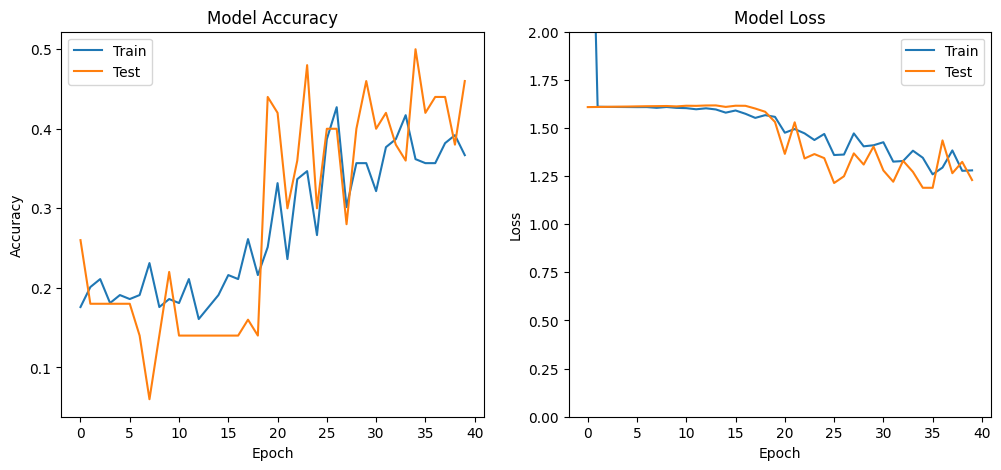

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.ylim((0,2))
plt.xlabel('Epoch')
plt.legend()

plt.show()

2/2 [==============================] - 0s 110ms/step
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.25      0.71      0.37         7
           2       0.00      0.00      0.00         9
           3       0.70      1.00      0.82        14
           4       0.33      0.43      0.38         7

    accuracy                           0.46        50
   macro avg       0.46      0.44      0.34        50
weighted avg       0.54      0.46      0.37        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


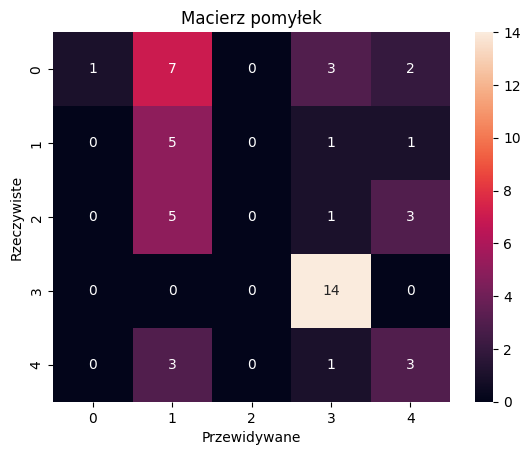

In [ ]:
y_pred = model.predict(X_test)
y_test_one = np.argmax(y_test, axis=1)
predicted_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_one, predicted_classes))

# Macierz pomyłek
cm = confusion_matrix(y_test_one, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Macierz pomyłek')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidywane')
plt.show()

# Zadanie 3
- Wygenerowanie mel-spektrogramów,
- Stworzenie modelu sieci CNN,
- Ocena Klasyfikacji - krzywe uczenia, metryki klasyfikatora, macierz pomyłek.

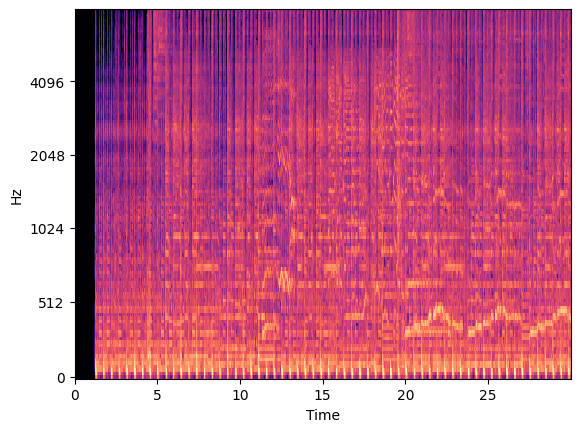

In [ ]:
audio_data = librosa.load(csv_dataframe['Sciezka'][0].replace("\'", "_").replace('\"', '_'))
S = librosa.feature.melspectrogram(y=audio_data[0], sr=audio_data[1], n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=audio_data[1], fmax=8000)

In [ ]:
print(S_dB.shape)

(128, 1292)


In [ ]:
print(img.get_coordinates().shape)

(129, 1293, 2)


In [ ]:
X = []
y = []
for i in range(len(csv_dataframe.index)):
  audio_data = librosa.load(csv_dataframe['Sciezka'][i].replace("\'", "_").replace('\"', '_'))
  S = librosa.feature.melspectrogram(y=audio_data[0], sr=audio_data[1], n_mels=128, fmax=8000)
  spectrogram = librosa.power_to_db(S, ref=np.max)
  genre = csv_dataframe['Gatunek'][i]
  X.append(spectrogram)
  y.append(genres.index(genre))
  if(i%10 == 0):
    print(i)

print(y)

X = np.array(X)[..., np.newaxis]
y = np.array(to_categorical(y))
X = (X - np.min(X)) / (np.max(X) - np.min(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(genres), activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=8)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
(199, 128, 1292, 1)
(199, 5)
(50, 128, 1292, 1)
(50, 5)
Epoch 1/20
25/25 [==============================] - 3s 58ms/step - loss: 3.9035 - accuracy: 0.1709 - val_lo

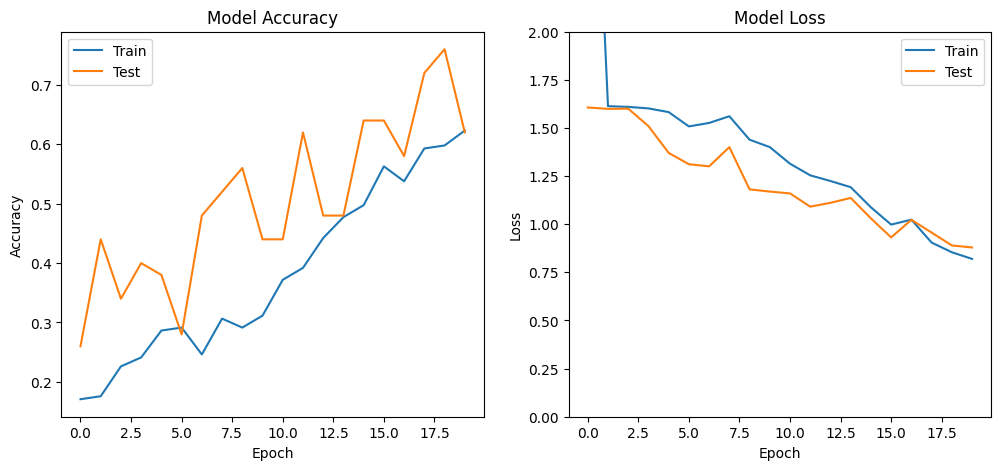

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.ylim((0,2))
plt.xlabel('Epoch')
plt.legend()

plt.show()

2/2 [==============================] - 1s 172ms/step
              precision    recall  f1-score   support

           0       0.80      0.31      0.44        13
           1       1.00      0.43      0.60         7
           2       0.42      0.89      0.57         9
           3       0.93      1.00      0.97        14
           4       0.25      0.29      0.27         7

    accuracy                           0.62        50
   macro avg       0.68      0.58      0.57        50
weighted avg       0.72      0.62      0.61        50



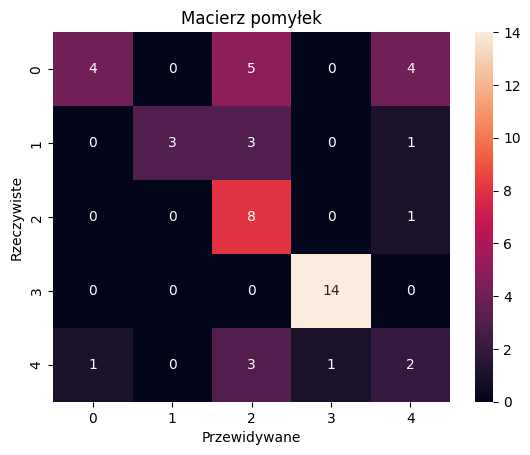

In [ ]:
y_pred = model.predict(X_test)
y_test_one = np.argmax(y_test, axis=1)
predicted_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_one, predicted_classes))

# Macierz pomyłek
cm = confusion_matrix(y_test_one, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Macierz pomyłek')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidywane')
plt.show()